# Estimate Noisy Envelope
---
This notebook estimates Noisy [1,2] envelopes from generated movies. 

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [1]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy as sci
from scipy.sparse.linalg import lsqr
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def plot_envelope(envelope):
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    envelope.plot(ax=ax[0])
    envelope.sel(x=0).plot(ax=ax[1])
    plt.tight_layout()
    
def compare_envelopes(env1, env2):
    data1, data2 = env1.data, env2.data
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    im = ax[0].imshow(np.abs(data1 - data2))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax)
    
    ax[0].set_title('Absolute difference', fontsize=16)
    ax[1].plot(np.abs(data1[int(data1.shape[0]/2),:] - data2[int(data2.shape[0]/2),:]))
    ax[1].set_title('Center slice abs-diff', fontsize=16)
    plt.tight_layout()

## Forward Model

In [5]:
advection = pynoisy.advection.disk(64, 64)
diffusion = pynoisy.diffusion.ring(64, 64)
solver = pynoisy.forward.NoisySolver(64, 64, advection, diffusion)
random_fields = solver.run_asymmetric(num_frames=50, num_samples=2, n_jobs=2)

# Save field
random_fields.to_netcdf('random_fields.nc')

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 83.67it/s]


<IPython.core.display.Javascript object>


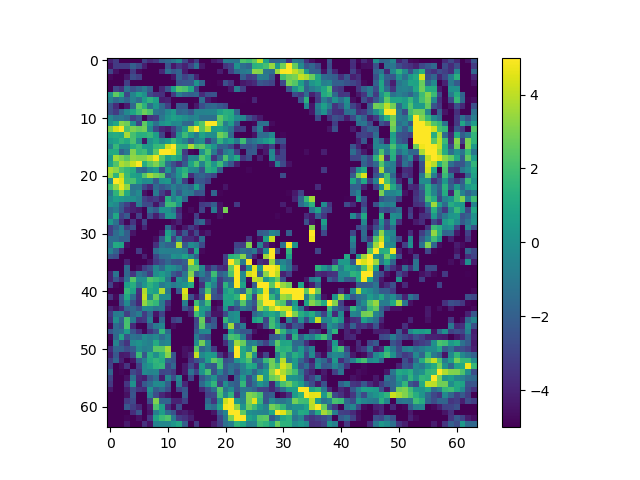

In [6]:
%matplotlib notebook
anim = random_fields[0].noisy_methods.get_animation(vmin=-5, vmax=5)

## Inverse Model

### Load Random Fields

Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


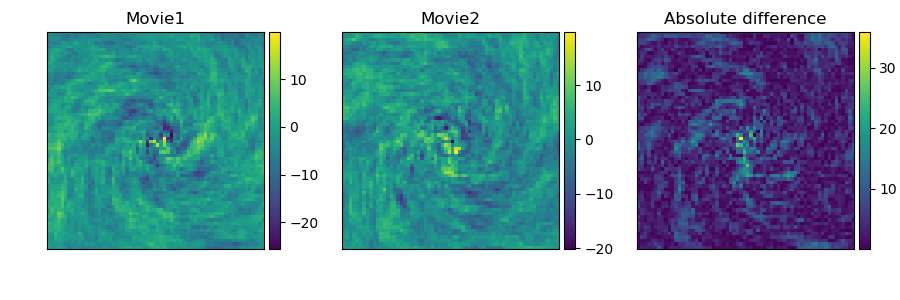

interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

In [7]:
random_fields = xr.load_dataarray('random_fields.nc')
%matplotlib notebook
pynoisy.utils.compare_movie_frames(random_fields.isel(sample=0), random_fields.isel(sample=1))

### Solve Inverse problem

<IPython.core.display.Javascript object>


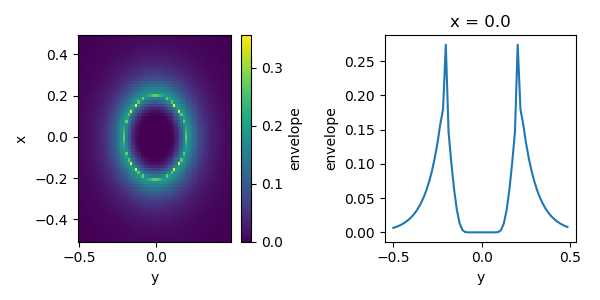

In [9]:
envelope = pynoisy.envelope.ring(64, 64, photon_ring_thickness=0.025,
                                 photon_ring_decay=200, inner_decay=12, ascent=.65)
%matplotlib notebook
plot_envelope(envelope)

<IPython.core.display.Javascript object>


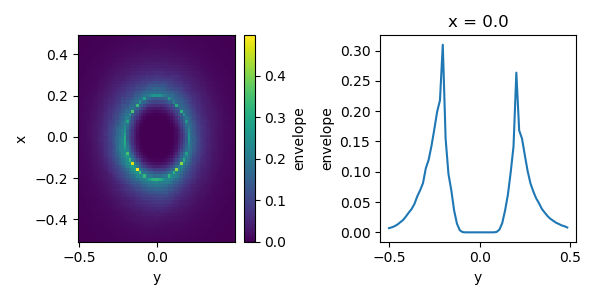

In [10]:
"""
Construct a sparse linear set of equations and solve for the envelope
"""
amplitude = 0.05
exp_grf = np.exp(-amplitude * random_fields)

b = np.array((envelope * exp_grf[0]).transpose('t', 'x', 'y', transpose_coords=False)).ravel()
diags = np.array(exp_grf[1]).reshape(random_fields.sizes['t'], -1)
A = sci.sparse.diags(diags, offsets=np.arange(random_fields.sizes['t']) * -diags.shape[1], shape=[diags.shape[1]*diags.shape[0], diags.shape[1]])
sol = lsqr(A,b)[0]

envelope_rec = pynoisy.envelope.grid(data=sol.reshape(*envelope.sizes.values()))
plot_envelope(envelope_rec)

<IPython.core.display.Javascript object>


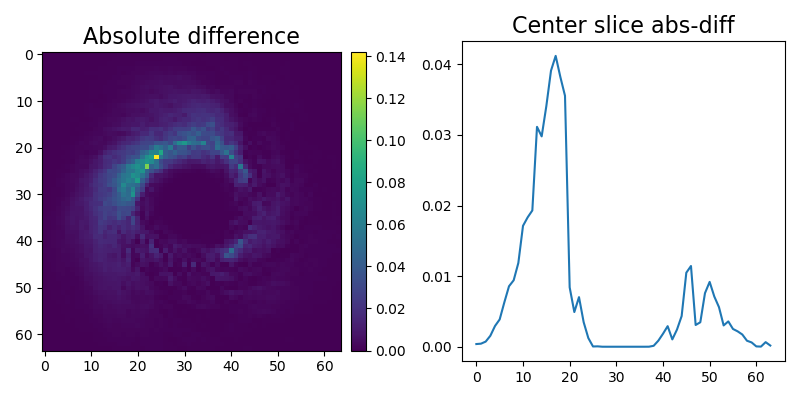

In [11]:
compare_envelopes(envelope, envelope_rec)